# TPM034A Machine Learning for socio-technical systems 
## `Lab session 04:  Explainable AI and energy prediction`

**Delft University of Technology**<br>
**Q2 2023**<br>
**Instructor:** Giacomo Marangoni <br>
**TAs:**  Francisco Garrido Valenzuela & Lucas Spierenburg <br>

### `Instructions`

**Lab sessions aim to:**<br>
* Show and reinforce how models and ideas presented in class are used in practice.<br>
* Help you gather hands-on machine learning skills.<br>

**Lab sessions are:**<br>
* Learning environments where you work with Jupyter notebooks and where you can get support from TAs and fellow students.<br> 
* Not graded and do not have to be submitted. 
### `Use of AI tools`
AI tools, such as ChatGPT and Co-pilot, are great tools to assist with programming. Moreover, in your later careers you will work in a world where such tools are widely available. As such, we **encourage** you to use AI tools **effectively** (both in the lab sessions and assignments). However, be careful not to overestimate the capacity of AI tools! AI tools cannot replace you: you still have to conceptualise the problem, dissect it and structure it, to conduct proper analysis and modelling. We recommend being especially **reticent** with using AI tools for the more conceptual and reflective oriented questions. 
### `Workspace set-up`

**Option 1: Local environment**<br>
Uncomment the following cell if you are running this notebook on your local environment. This will install all dependencies on your Python version.

In [69]:
#!pip install -r requirements_lab04.txt

**Option 2: Google Colab**<br>
Uncomment the following cells code lines if you are running this notebook on Colab

In [70]:
#!git clone https://github.com/TPM034A/Q2_2023
#!pip install -r Q2_2023/requirements_lab04.txt
#!mv "/content/Q2_2023/Lab_sessions/lab_session_04/data" /content/data

### `Application: Explaining the prediction of the next 24-hour electricity load` <br>

#### **Introduction**
In this lab session we will train a Linear regression (LR) and a Random forest regressor (RF) to predict the **next 24-hour electricity load** of a household. We will then use the tools of Explainable AI, and in particular SHAP, to better understand how specific prediction are influenced by different features.

#### **Data**

1. `data/load.pkl`: A pickle file with a pandas.DataFrame of overall Wh hourly energy consumption of a household from the REFIT Electrical Load Measurements dataset, collected over a period of about two years.
2. `data/devices.pkl`: A pickle file with a pandas.DataFrame of normalized weather variables: `dwpt` is Dew Point (related to moisture), `rhum` is relative humidity, `temp` is temperature, `wdir` is wind direction, `wspd` is wind speed.


### Load and preprocess the datasets

In [72]:
# Use pd.read_pickle to load 'data/load.pkl'

# Check that you get a similar pd.Series:
# Time
# 2013-09-25 19:00:00    410.766578
# 2013-09-25 20:00:00    417.421053
# 2013-09-25 21:00:00    508.165821
# ...

In [73]:
import pandas as pd
load = pd.read_pickle('data/load.pkl')
load.head()

Time
2013-09-25 19:00:00    410.766578
2013-09-25 20:00:00    417.421053
2013-09-25 21:00:00    508.165821
2013-09-25 22:00:00    264.194492
2013-09-25 23:00:00    296.035836
Freq: 60T, Name: load, dtype: float64

In [74]:
# How many observations does the dataset have? What is the overall time range?

In [75]:
load.sort_index(inplace=True)
load.index[[0,-1]]
# or
load.index.to_series().describe()

count                  14752
mean     2014-07-30 02:30:00
min      2013-09-25 19:00:00
25%      2014-02-26 10:45:00
50%      2014-07-30 02:30:00
75%      2014-12-30 18:15:00
max      2015-06-02 10:00:00
Name: Time, dtype: object

In [76]:
# Use pd.read_pickle to load 'data/weather.pkl'

# Check that you have a pd.DataFrame with columns
# ['temp', 'dwpt', 'rhum', 'wdir', 'wspd']
# and index equal to the load index

In [77]:
weather = pd.read_pickle('data/weather.pkl')
weather.head()

,temp,dwpt,rhum,wdir,wspd
Time,,,,,
2013-09-25 19:00:00,0.833333,0.740741,0.774074,0.114286,0.230958
2013-09-25 20:00:00,0.750000,0.740741,0.733333,0.085714,0.186732
2013-09-25 21:00:00,0.833333,0.703704,0.737037,0.057143,0.319410
2013-09-25 22:00:00,0.833333,0.703704,0.737037,0.171429,0.452088
2013-09-25 23:00:00,0.916667,0.629630,0.703704,0.142857,0.503686


In [78]:
# Add an "hour" column to the load df, corresponding to the integer hour of the index
# e.g. 2013-09-25 19:00:00 --> 19
# Hint: convert index into a pd.Series and use the .hour accessor

In [79]:
load_df = load.to_frame()
load_df['hour'] = load_df.index.hour
load_df.head()

,load,hour
Time,,
2013-09-25 19:00:00,410.766578,19
2013-09-25 20:00:00,417.421053,20
2013-09-25 21:00:00,508.165821,21
2013-09-25 22:00:00,264.194492,22
2013-09-25 23:00:00,296.035836,23


In [80]:
# Add 3 columns to the load df
# load_lag_24, load_lag_48 and load_lag_72
# corresponding to the value of load 24, 48 and 72 hourse before, respectively
# Hint: use the .shift function

# check as example the first five 21:00 samples to make sure you computed the lags correctly

In [81]:
for x in [24, 48, 72]:
    load_df[f'load_lag_{x}'] = load_df['load'].shift(x)
load_df[load_df.hour == 21].head(5)

,load,hour,load_lag_24,load_lag_48,load_lag_72
Time,,,,,
2013-09-25 21:00:00,508.165821,21,NaN,NaN,NaN
2013-09-26 21:00:00,316.108808,21,508.165821,NaN,NaN
2013-09-27 21:00:00,615.919571,21,316.108808,508.165821,NaN
2013-09-28 21:00:00,563.073630,21,615.919571,316.108808,508.165821
2013-09-29 21:00:00,335.103918,21,563.073630,615.919571,316.108808


In [82]:
# Add 7 dummy columns, each one with value 0 or 1 for each day of the week of the corresponding index,
# named "day_name_monday", "day_name_tuesday", ... , "day_name_saturday" (skipping Sunday)
# Hint: use index.dayofweek and pd.get_dummies

# check as example the first seven 21:00 samples to make sure you computed the day_name columns correctly

In [83]:
import calendar
day_name_list = [x.lower() for x in calendar.day_name]
load_df2 = load_df.copy()
load_df2['day_name'] = load_df2.index.dayofweek
load_df2['day_name'] = load_df2['day_name'].replace(dict(zip(range(7), day_name_list)))
load_df2 = pd.get_dummies(
    load_df2,
    prefix='day_name',
    columns=['day_name'],
    dtype=int
).drop('day_name_sunday', axis=1)
load_df2[load_df2.hour == 21].head(7)

,load,hour,load_lag_24,load_lag_48,load_lag_72,day_name_friday,day_name_monday,day_name_saturday,day_name_thursday,day_name_tuesday,day_name_wednesday
Time,,,,,,,,,,,
2013-09-25 21:00:00,508.165821,21,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-26 21:00:00,316.108808,21,508.165821,NaN,NaN,0,0,0,1,0,0
2013-09-27 21:00:00,615.919571,21,316.108808,508.165821,NaN,1,0,0,0,0,0
2013-09-28 21:00:00,563.073630,21,615.919571,316.108808,508.165821,0,0,1,0,0,0
2013-09-29 21:00:00,335.103918,21,563.073630,615.919571,316.108808,0,0,0,0,0,0
2013-09-30 21:00:00,NaN,21,335.103918,563.073630,615.919571,0,1,0,0,0,0
2013-10-01 21:00:00,NaN,21,NaN,335.103918,563.073630,0,0,0,0,1,0


In [84]:
# Merge the weather and the load df
# Hint: use df.join

In [85]:
load_df3 = load_df2.join(weather)
load_df3.head()

,load,hour,load_lag_24,load_lag_48,load_lag_72,day_name_friday,day_name_monday,day_name_saturday,day_name_thursday,day_name_tuesday,day_name_wednesday,temp,dwpt,rhum,wdir,wspd
Time,,,,,,,,,,,,,,,,
2013-09-25 19:00:00,410.766578,19,NaN,NaN,NaN,0,0,0,0,0,1,0.833333,0.740741,0.774074,0.114286,0.230958
2013-09-25 20:00:00,417.421053,20,NaN,NaN,NaN,0,0,0,0,0,1,0.750000,0.740741,0.733333,0.085714,0.186732
2013-09-25 21:00:00,508.165821,21,NaN,NaN,NaN,0,0,0,0,0,1,0.833333,0.703704,0.737037,0.057143,0.319410
2013-09-25 22:00:00,264.194492,22,NaN,NaN,NaN,0,0,0,0,0,1,0.833333,0.703704,0.737037,0.171429,0.452088
2013-09-25 23:00:00,296.035836,23,NaN,NaN,NaN,0,0,0,0,0,1,0.916667,0.629630,0.703704,0.142857,0.503686


In [86]:
# Plot the load of a single day, e.g. 2013-12-12
# Does the shape make sense?

<Axes: xlabel='Time'>

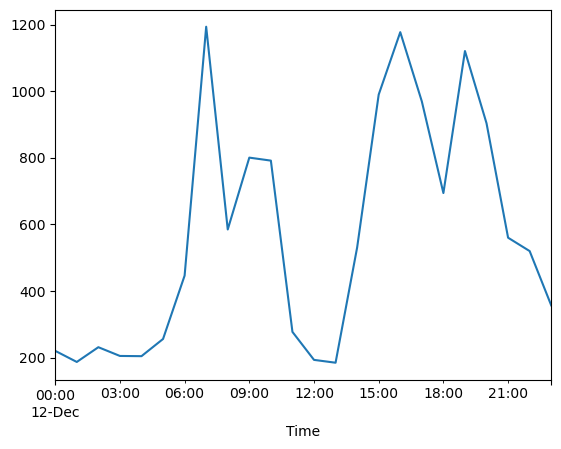

In [87]:
# Peaks possibly at breakfast, pre and post dinner
load_df3.loc['2013-12-12','load'].plot()

In [88]:
# Plot the average and confidence interval of hourly load for weekdays vs weekends from '2013-11-01' onwards
# Hint: use seaborn.lineplot
# Do you observe any difference?

<Axes: xlabel='hour', ylabel='load'>

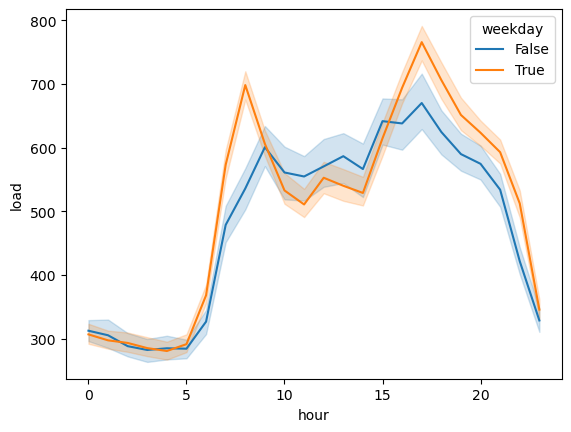

In [89]:
# During weekdays higher morning / evening peaks, possibly following classic workday routine.
import seaborn as sb
load_df3b = load_df3.copy()
load_df3b['weekday'] = (load_df3b.index.dayofweek <= 4)
sb.lineplot(x='hour', y='load', hue='weekday', errorbar=('ci', 90), n_boot=200, data=load_df3b.loc['2013-11-01':])

In [90]:
# Add dummies "hour_1", "hour_2", ... "hour_23" (skipping "hour_0"), equal to 1 for the corresponding index hour
# Hint: use pd.get_dummies

In [91]:
load_df4 = pd.get_dummies(
    load_df3,
    prefix='hour',
    columns=['hour'],
    dtype=int
).drop('hour_0', axis=1)

### Train a linear regression model

In [92]:
# Train a linear regression model to predict load of 2014-12-12 based on features computed above.
# Use the period 2013-11-01 to 2014-12-11 for training.

In [93]:
load_df5 = load_df4.dropna()
X_train_lr = load_df5.loc['2013-11-01':'2014-12-11', load_df5.columns != 'load']
y_train_lr = load_df5.loc['2013-11-01':'2014-12-11', 'load']
X_test_lr = load_df5.loc['2014-12-12', load_df5.columns != 'load']
y_test_lr = load_df5.loc['2014-12-12', 'load']
X_train_lr.head()

,load_lag_24,load_lag_48,load_lag_72,day_name_friday,day_name_monday,day_name_saturday,day_name_thursday,day_name_tuesday,day_name_wednesday,temp,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
Time,,,,,,,,,,,,,,,,,,,,,
2013-11-01 00:00:00,258.576667,260.596667,535.465000,1,0,0,0,0,0,0.819444,...,0,0,0,0,0,0,0,0,0,0
2013-11-01 01:00:00,193.818333,179.436667,348.038333,1,0,0,0,0,0,0.916667,...,0,0,0,0,0,0,0,0,0,0
2013-11-01 02:00:00,253.075000,239.530000,234.813022,1,0,0,0,0,0,0.916667,...,0,0,0,0,0,0,0,0,0,0
2013-11-01 03:00:00,198.595486,204.290541,203.381271,1,0,0,0,0,0,0.916667,...,0,0,0,0,0,0,0,0,0,0
2013-11-01 04:00:00,235.085142,239.170854,214.137124,1,0,0,0,0,0,0.902778,...,0,0,0,0,0,0,0,0,0,0


In [94]:
from sklearn.linear_model import LinearRegression
import numpy as np
model_lr = LinearRegression().fit(X_train_lr, y_train_lr)

In [95]:
# Compute the root mean squared error

In [96]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
y_pred_lr = model_lr.predict(X_test_lr)
mse_lr = mean_squared_error(y_test_lr, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print(rmse_lr)

215.86829798732597


### Explain a LR model with SHAP

In [97]:
# Plot the SHAP values for the test set (load values for the hours of the day 2014-12-12)
# Hint: use shap.Explainer and shap.plots.beeswarm

In [98]:
import shap
X100_lr = shap.sample(X_train_lr, 100)
explainer_lr = shap.Explainer(model_lr.predict, X100_lr)
shap_values_lr = explainer_lr(X_test_lr)

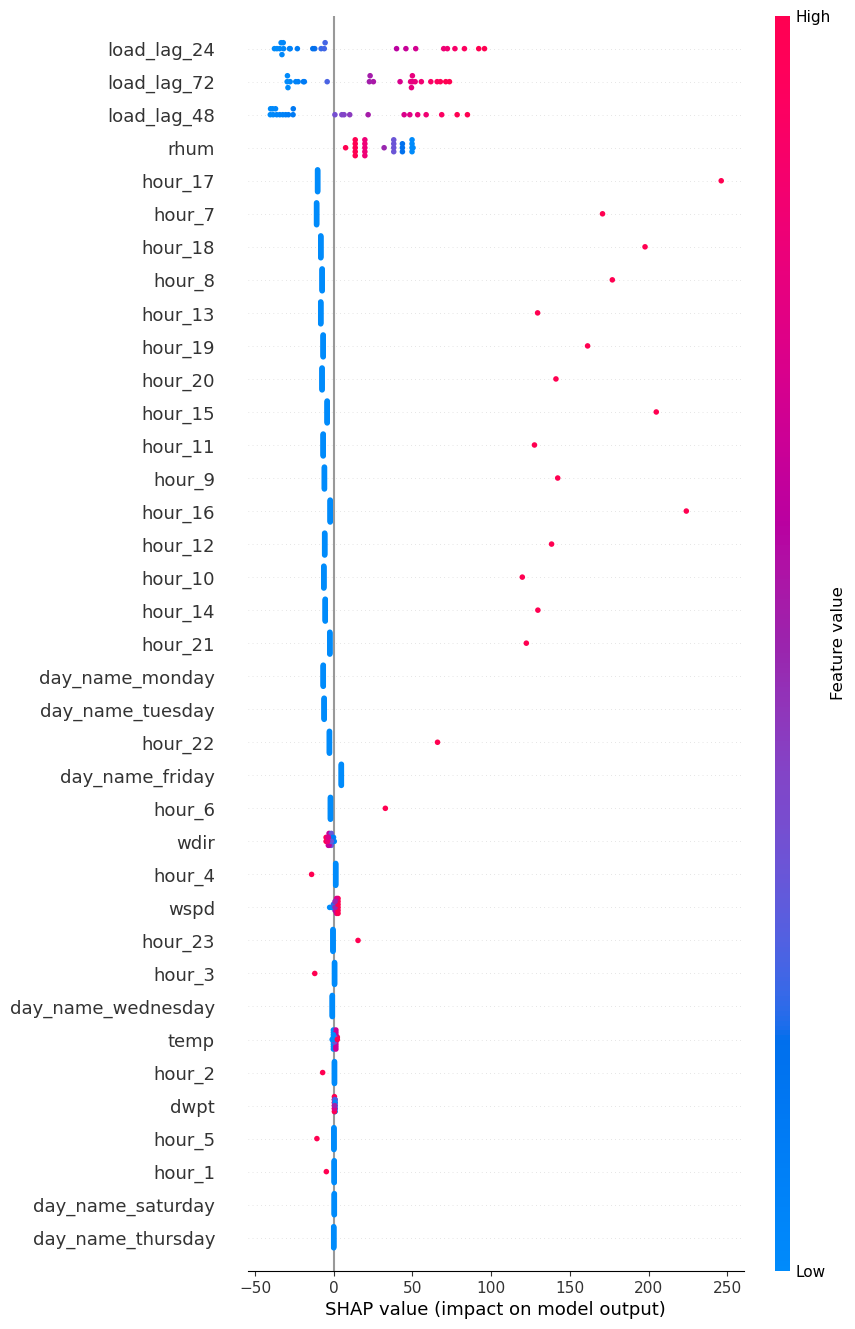

In [99]:
shap.plots.beeswarm(shap_values_lr, max_display=50)

### Train a Random Forest Regressor

In [100]:
# Train a random forest regressor model to predict load of 2014-12-12.
# Use the period 2013-11-01 to 2014-12-11 for training.
# Do not use the dummies computed above. Use the following features instead:
# ['hour', 'load_lag_24', 'load_lag_48', 'load_lag_72', 'temp',
#    'dwpt', 'rhum', 'wdir', 'wspd', 'weekday']
# where hour and weekday are int

In [101]:
from sklearn.ensemble import RandomForestRegressor
load_df6 = load_df.join(weather).dropna()
load_df6['weekday'] = load_df6.index.dayofweek.astype(int)
load_df6['hour'] = load_df6['hour'].astype(int)
load_df6.head()

,load,hour,load_lag_24,load_lag_48,load_lag_72,temp,dwpt,rhum,wdir,wspd,weekday
Time,,,,,,,,,,,
2013-09-28 19:00:00,959.934673,19,769.869863,496.906780,410.766578,0.486111,0.666667,0.518519,0.200000,0.503686,5
2013-09-28 20:00:00,893.268376,20,883.491935,505.720339,417.421053,0.680556,0.629630,0.592593,0.200000,0.452088,5
2013-09-28 21:00:00,563.073630,21,615.919571,316.108808,508.165821,0.680556,0.592593,0.555556,0.228571,0.547912,5
2013-09-28 22:00:00,387.428082,22,402.123499,246.125850,264.194492,0.680556,0.592593,0.555556,0.171429,0.407862,5
2013-09-28 23:00:00,296.727425,23,266.485269,228.288696,296.035836,0.819444,0.555556,0.585185,0.171429,0.407862,5


In [102]:
X_train_rf = load_df6.loc['2013-11-01':'2014-12-11', load_df6.columns != 'load']
y_train_rf = load_df6.loc['2013-11-01':'2014-12-11', 'load']
X_test_rf = load_df6.loc['2014-12-12', load_df6.columns != 'load']
y_test_rf = load_df6.loc['2014-12-12', 'load']
model_rf = RandomForestRegressor(random_state=0).fit(X_train_rf, y_train_rf)

In [103]:
# What is the root mean squared error for the test set? Does the accuracy improve with respect to the linear model?

In [104]:
# RF improves on the LR
y_pred_rf = model_rf.predict(X_test_rf)
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print(rmse_rf)

207.08752450481606


### Explain a RF model with SHAP

In [105]:
# What is the expected energy consumption knowing the weekday?
# What is the weekday with the highest/lowest expected consumption?
# 
# Hint: use shap.partial_dependence_plot

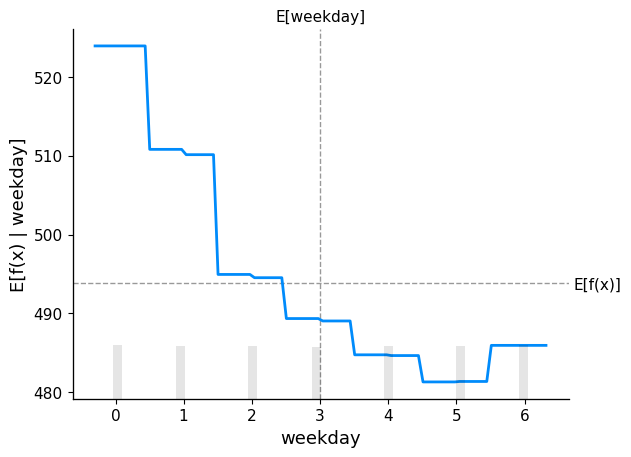

In [106]:
fig, ax = shap.partial_dependence_plot(
    "weekday",
    model_rf.predict,
    X_train_rf,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

In [107]:
# Compare with the mean load of the train set grouped by weekday: are they different? If so, why?

In [108]:
# The numbers are aligned but different. 
# The PDP considers the individual impact of weekday all other features being equal,
# and reflects the importance that the model attributes to weekday.
# The groupby mean is a descriptive statistics of the training data.
y_train.groupby(y_train.index.weekday).mean()

Time
0    522.670184
1    521.071099
2    491.700360
3    485.170574
4    480.278267
5    467.890707
6    470.063741
Name: load, dtype: float64

In [109]:
# What is the expected energy consumption knowing the hour? What about temperature? Does the model behavior make sense?

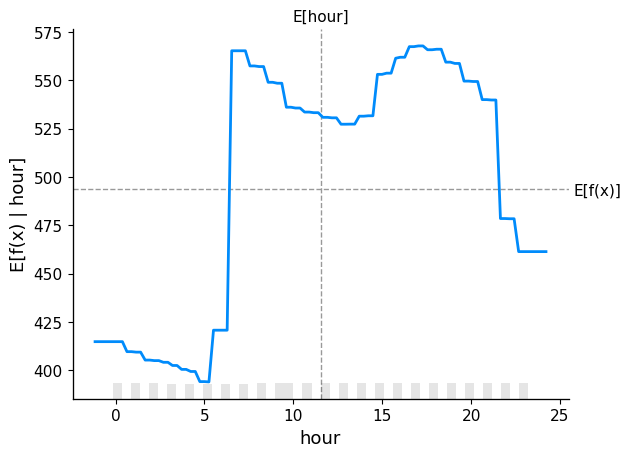

In [110]:
# Hour: classic double peak, likely at breakfast and dinner
fig, ax = shap.partial_dependence_plot(
    "hour",
    model_rf.predict,
    X_train_rf,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

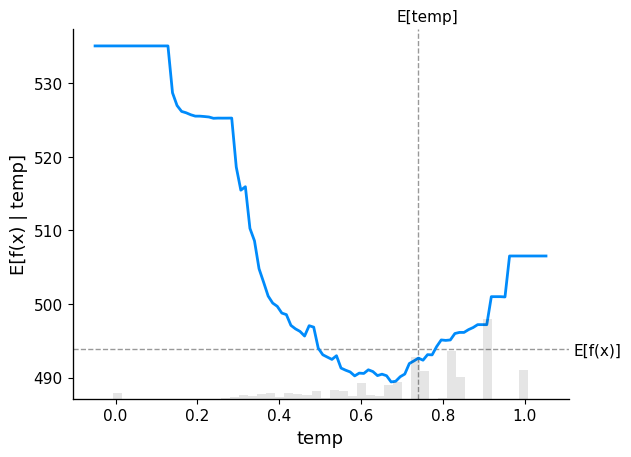

In [111]:
# Temperature: classic U-shape, people more likely to stay home for low/high temps
fig, ax = shap.partial_dependence_plot(
    "temp",
    model_rf.predict,
    X_train_rf,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

In [112]:
# Plot the SHAP values of each feature for each of the test samples.
# Hint: use shap.plots.beeswarm

In [113]:
X100 = shap.sample(X_train_rf, 100, random_state=0)
explainer_rf = shap.Explainer(model_rf.predict, X100)
shap_values_rf = explainer_rf(X_test_rf)

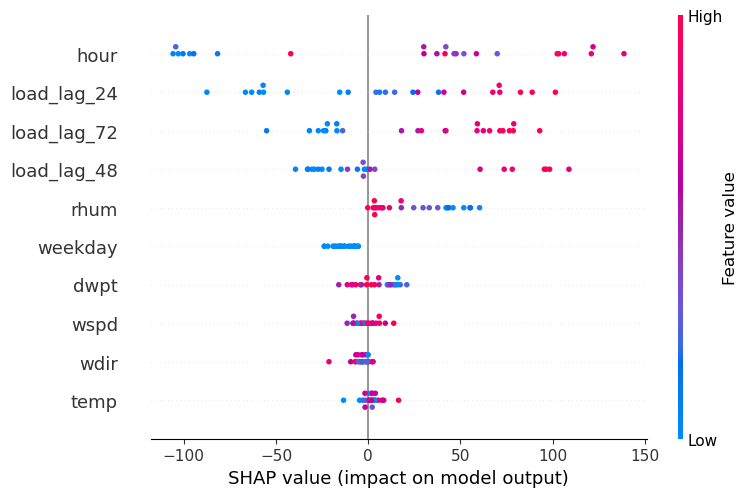

In [114]:
shap.plots.beeswarm(shap_values_rf)

In [115]:
# What is the most predictive feature? What is the least predictive? How do you interpret it?
# Hint: use shap.plots.bar

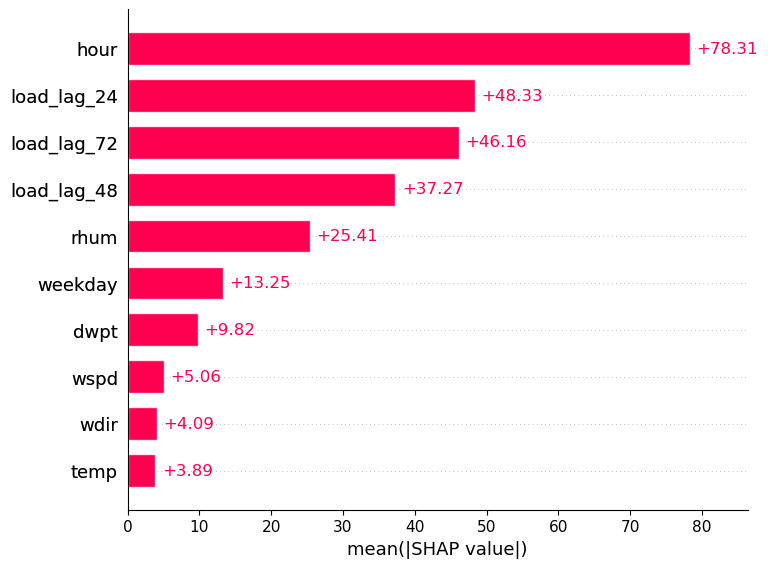

In [116]:
# Most predictive:
shap.plots.bar(shap_values_rf)

In [131]:
# Explain the 15:00 and 20:00 prediction of the test. What observations can you make? 
# Hint: use shap.plots.waterfall

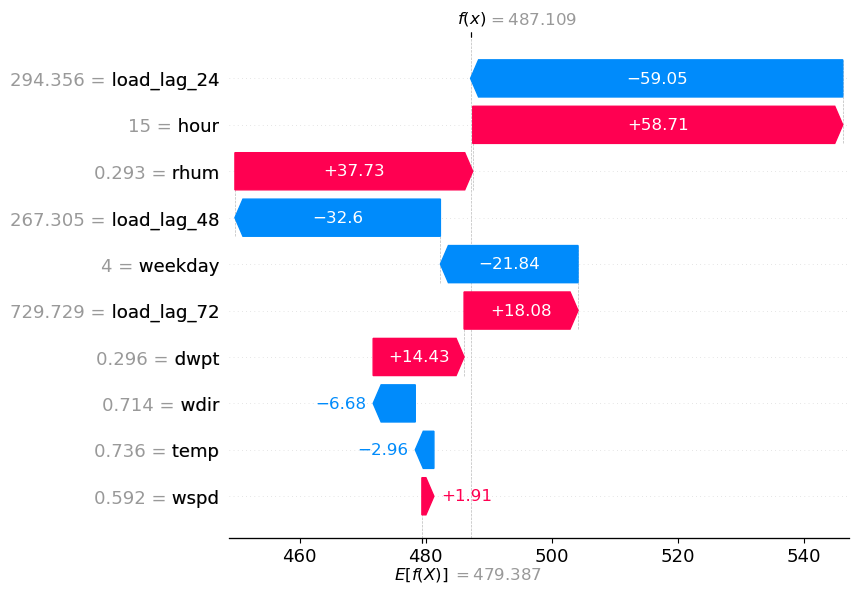

In [130]:
shap.plots.waterfall(shap_values_rf[15])

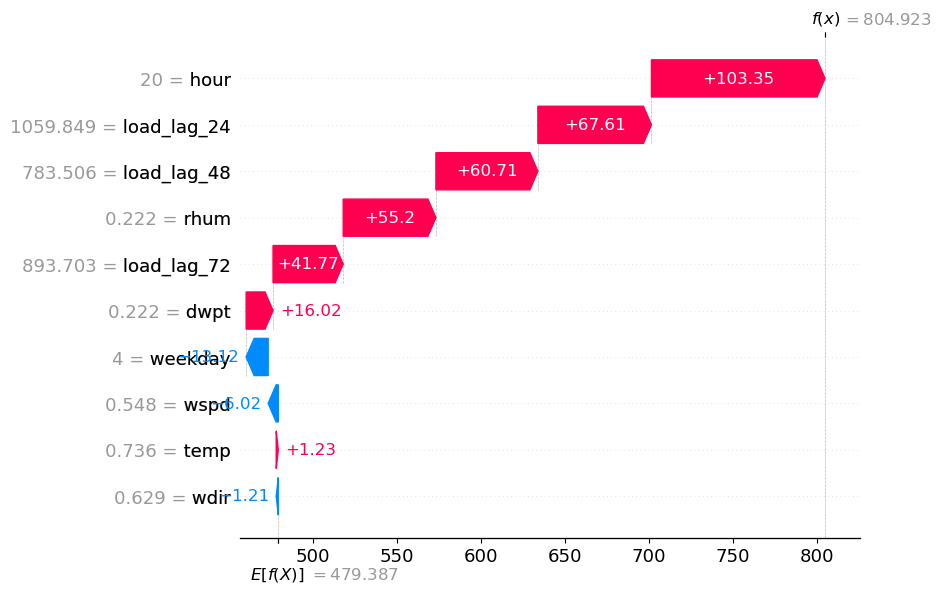

In [132]:
# In general, high autocorrelation (<->lag variables) and habit-driven (<->hour) consumption.
# In the evening, less influence of weather variables and weekday.
shap.plots.waterfall(shap_values_rf[20])

### Reflections

In [120]:
# Reflect on how the information above could be useful for environmental reasons.

In [121]:
# For the energy provider, better planning to cover peaks, and info to best design energy demand response.
# For the consumer, better awareness of patterns of consumption, and incentive to shift load to align with renewables availability.